In [2]:
# Looking at signal error from error in probe pulse length
# EOS-BPM Longitudinal resolution study
import copy
from cycler import cycler;
import matplotlib.pyplot as plt;
import numpy as np;
from scipy.interpolate import interp1d;
from scipy.constants import c;
from scipy.signal import find_peaks;
import sys;
import time;
sys.path.insert(0, r'../../python/')
import phase_retard as pr;

# Colors for plotting.
plot_colors = ['#332288', '#88CCEE', '#44AA99', '#117733', '#999933', \
               '#DDCC77','#CC6677', '#882255',  '#AA4499'];

cy = cycler('color', plot_colors);


# Bunch parameters
Q_drive    = 1.5e-9;
sigz_drive = 5.2e-6;
sigt_drive = sigz_drive/c;
Q_wit      = 0.5e-9;
sigz_wit   = 5.2e-6;
sigt_wit   = sigz_wit/c;
del_z      = 175e-6;
del_t      = del_z/c;
x_drive    = 3.0e-3;
y_drive    = 0.0;
x_wit      = 3.0e-3;
y_wit      = 0.0;
r_drive    = np.sqrt(x_drive**2 + y_drive**2);
r_wit      = np.sqrt(x_wit**2 + y_wit**2);

drive      = {'Q':Q_drive, 'sig_t':sigt_drive, 'x' : x_drive, 'y' : y_drive};
wit        = {'Q':Q_wit, 'sig_t':sigt_wit, 'x' : x_wit, 'y' : y_wit};

# Crystal parameters (type and thickness)
ctype = 'GaP';
d   = 100e-6;
# Probe parameters
y0      = 800e-9;
a_laser = 0 * np.pi / 180;
z_match = 0;
tau     = np.linspace(-200, 800, 5000) * 1e-15;
probe = {'y0'     :y0, 
         'a_laser': a_laser, 
         'z_match': z_match, 
         'chirp'  : True,
         'width'  : 27e-9};

# time array for THz field
N         = 8000;
dt        = drive['sig_t']/10;
t         = np.linspace(- N * dt/2, N * dt/2, N);

# Compuatational parameters
nslice = int(d * 1e6);
base_params  = {'ctype'    : ctype, 
                't'       : t, 
                'tau'     : tau,
                'nslice'  : nslice,
                'beam1'   : drive,
                'beam2'   : wit,
                't_off'   : del_t,
                'plot'    : False,
                'verbose' : False, 
                'pockel'  : True, 
                'ref'     : True,
                'save'    : False,
                'probe'   : probe}; 

# Function for quick plotting 
def makefig():
    fig = plt.figure(figsize = (6,6), dpi = 200);
    ax  = fig.gca();
    ax.set_prop_cycle(cy);
    return fig, ax;

<IPython.core.display.Javascript object>


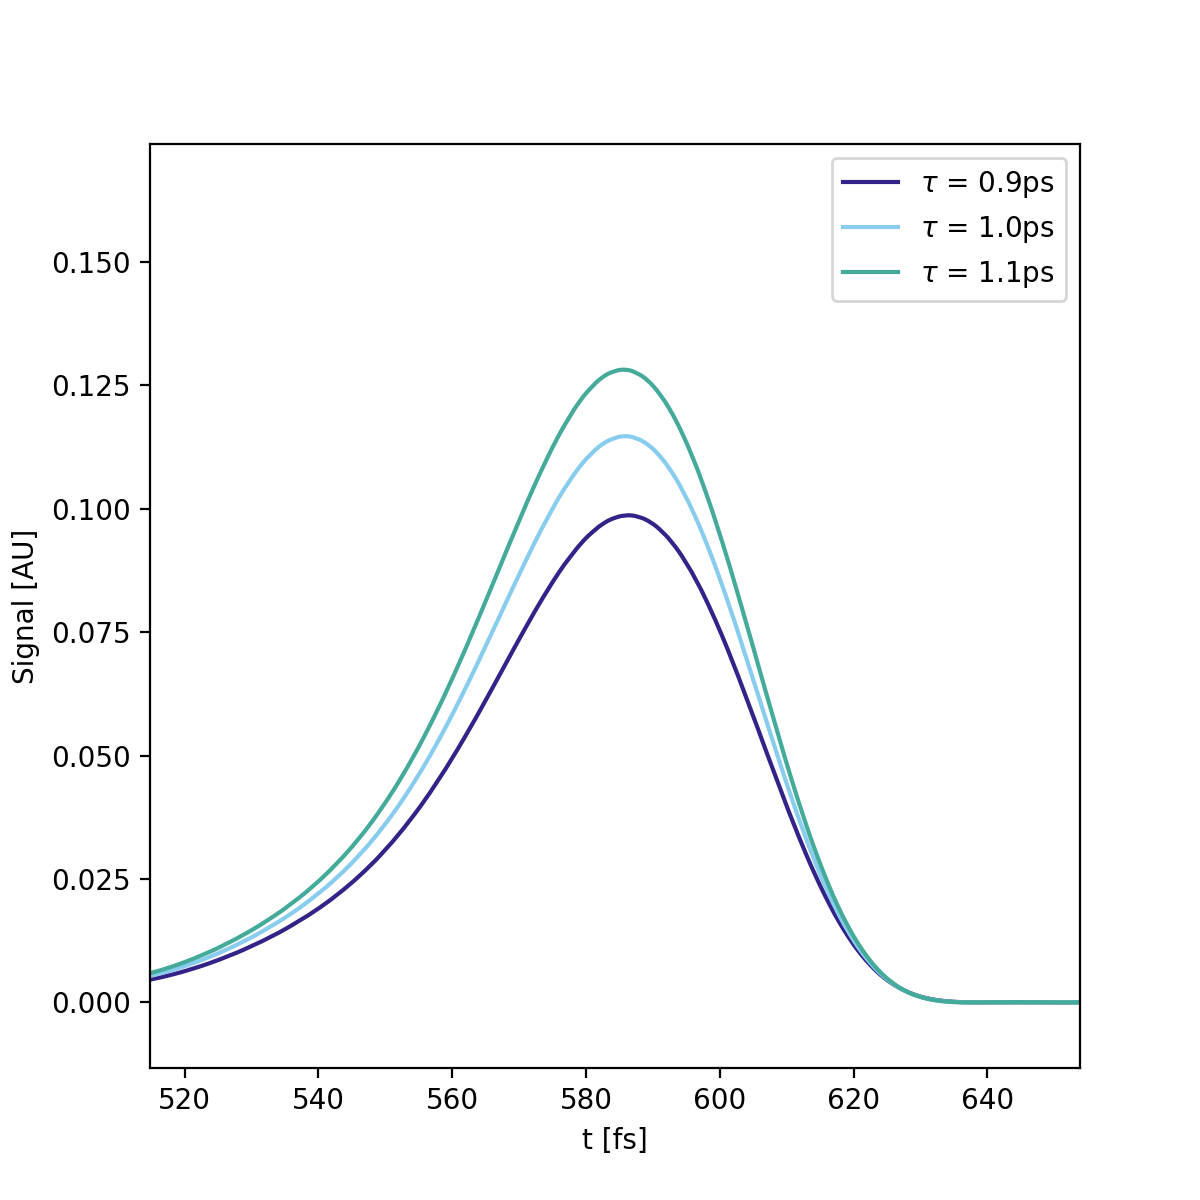

In [24]:
%matplotlib notebook
# Compute signal for 3 chirped pulses with a varying length
error = np.array([-0.1, 0.0, 0.1]);
tstart = -200;
tend   = 800;
# Params for phase retard
params = copy.deepcopy(base_params);
params['det']  = 'cross';
params['d']    = 100e-6;
params['plot'] = False;
fig, ax = makefig();
signal = np.zeros((len(error), 5000));
taus   = np.zeros((len(error), 5000));
for i in range(len(error)):
    err = error[i];
    new_start = tstart + tstart * (err);
    new_end   = tend + tend * (err);
    tau = np.linspace(new_start, new_end, 5000) * 1e-15;
    params['tau'] = tau;
    # Get probe_pulse
    del_y = probe['width'];
    # Down-chirp (frequency decreases in time)
    y1    = y0 - (del_y / 2);
    y2    = y0 + (del_y/2);
    f0    = c / y0;
    # in Hz
    f1    = c / y1;
    f2    = c/y2;
    # chirp parameter
    T = abs(tau[0] - tau[-1])
    k = (f2 - f1) / T;
    b = np.pi * k;
    a = (2 * np.log(2)) / T**2;
    gm = a + 1j * b;
    E_probe = np.exp(-gm * tau**2) * np.exp(-1j * 2 * np.pi * f0 * tau);
    I_probe = np.absolute(E_probe)**2;
    dummy, dummy, gamma, taus[i] = pr.phase_retard(params)
    t_probe = taus[i] # + (err * 1000);
    signal[i] = I_probe * np.sin(gamma / 2)**2;
    ax.plot(t_probe, signal[i]/max(signal[i]), label = r'$\tau$ = ' + str(np.round(T*1e12, 2)) + 'ps');
ax.legend();
ax.set_xlabel('t [fs]');
ax.set_ylabel('Signal [AU]');
plt.show();